# Simple regression

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, cv_adaptation, one_model_inference, simple_cv_adaptation
from pcv.plots import plot_model_results, plot_fold_results, plot_rhats
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

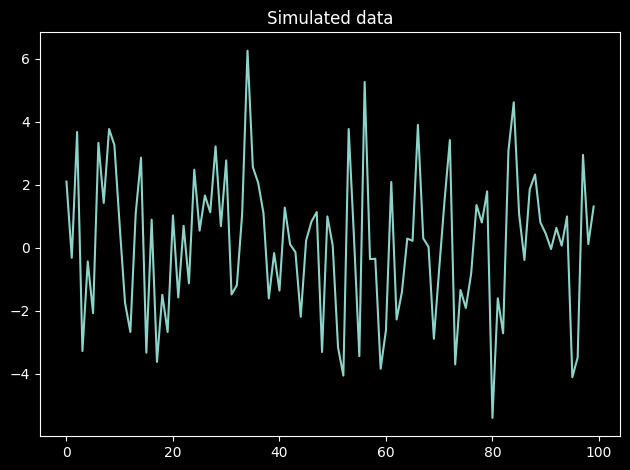

In [3]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.9]),
    sigsq0 = jnp.array(2.0))

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [4]:
K = 10
model = reg.get_model(y, X, K=K)

First, run model diagnostics.

In [5]:
idata, state = one_model_inference(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    model_id=0,
    num_chains=512,
    num_samples=2_000,
    warmup_iter=10_000,
    prior_only=False
)

GHMC alpha: 0.6132, delta: 0.3066, step size: 0.4761


In [6]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.880,0.130,0.635,1.123,0.0,0.0,204421.0,319831.0,1.0
beta[1],0.970,0.124,0.736,1.202,0.0,0.0,197088.0,310854.0,1.0
beta[2],1.005,0.110,0.797,1.213,0.0,0.0,196178.0,308296.0,1.0
beta[3],0.887,0.122,0.657,1.117,0.0,0.0,189609.0,300334.0,1.0
sigsq,1.498,0.216,1.112,1.907,0.0,0.0,211856.0,308560.0,1.0


In [7]:
print(f"Saw {state.divergences.sum()} divergences")

Saw 0.0 divergences


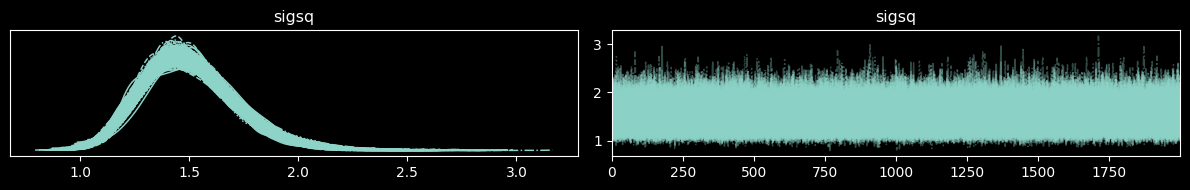

In [8]:
axes = az.plot_trace(idata, var_names=['sigsq'])
plt.tight_layout()

# Experimental Rhat thresholds

In [9]:
import numpy as np
sigsq_draws = np.array(az.extract(idata, var_names=['sigsq'], combined=False))
m, n = sigsq_draws.shape[:2]
print(f"m={m} chains, n={n} samples")

m=512 chains, n=2000 samples


In [10]:
# regular rhat
def compute_rhat(draws):
    m, n = draws.shape[:2]
    W = np.mean(np.var(draws, axis=1, ddof=1))
    B = n*np.var(np.mean(draws, axis=1), ddof=1)
    var_hat = (n - 1) / n * W + B / n
    return np.sqrt(var_hat / W)

rhat = compute_rhat(sigsq_draws)
rhat_arviz = float(az.rhat(idata, method='identity', var_names=['sigsq'])['sigsq'])
assert np.allclose(rhat_arviz, rhat)
print(f"our rhat={rhat}, arviz rhat={rhat_arviz}, hooray")

our rhat=1.000832486665163, arviz rhat=1.0008324866651628, hooray


In [11]:
# shuffle chains the mutable horrible slow way
def shuffle_draws(draws, breaks=100, with_replacement=True):
    draws_shuffled = np.empty_like(draws)
    start_at = 0
    chunks = np.split(draws, 100, axis=1)
    for chunk in chunks:
        m, chunk_len = chunk.shape[:2]
        end_at = start_at + chunk_len
        if with_replacement:
            idxs = np.random.choice(np.arange(m), m, replace=True)
            shuffled_chunk = chunk[idxs, :]
        else:
            shuffled_chunk = np.random.permutation(chunk)
        draws_shuffled[:,start_at:end_at] = shuffled_chunk
        start_at = end_at
    return draws_shuffled

In [12]:
def assess_rhat(draws, paramname, reps=1000, breaks=100, ax=None):
    rhat = compute_rhat(draws)
    rhat_draws = np.empty(reps)
    for i in range(len(rhat_draws)):
        rhat_draws[i] = compute_rhat(shuffle_draws(draws, breaks=breaks))
    ax = sns.kdeplot(rhat_draws, fill=True, ax=ax)
    ax.set_xlabel(r'$\hat{R}$')
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.axvline(rhat, color='red')
    ax.set_title(r'$\hat{R}$ for '+paramname+r' versus shuffled $\hat{R}$')

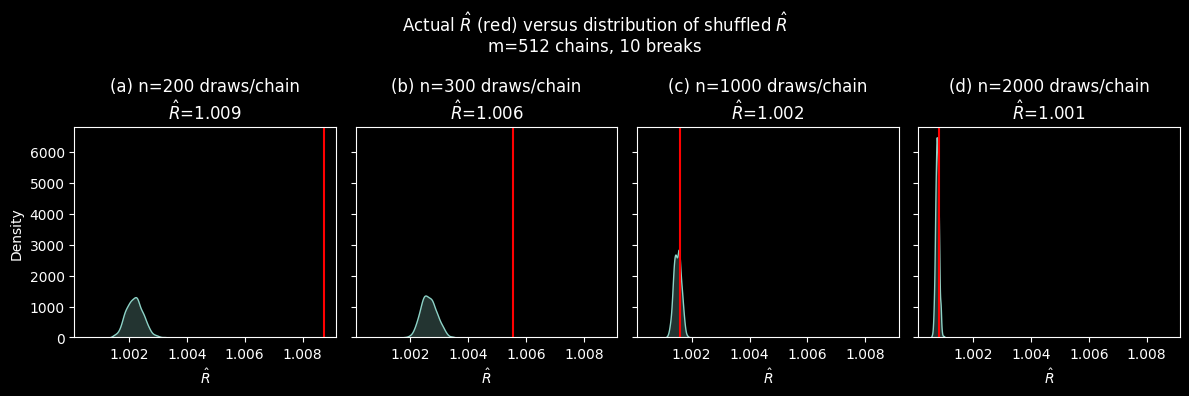

In [18]:
ns = [200, 300, 1000, 2000]
fig, axes = plt.subplots(1, len(ns), figsize=(12, 4), sharex=True, sharey=True)
brks = 10
for i, (ax, n) in enumerate(zip(axes.ravel(), ns)):
    assess_rhat(sigsq_draws[:,:n], r'$\sigma^2$', breaks=brks, ax=ax)
    a = chr(ord('a') + i)
    ax.set_title(f'({a}) n={n} draws/chain\n$\\hat{{R}}$={compute_rhat(sigsq_draws[:,:n]):.3f}')
fig.suptitle(f'Actual $\\hat{{R}}$ (red) versus distribution of shuffled $\\hat{{R}}$\nm={m} chains, {brks} breaks')
plt.tight_layout()

In [14]:
def assess_rhat_az(draws, paramname, method='rank', reps=1000, breaks=100, ax=None):
    rhat = float(az.rhat(idata, method=method, var_names=[paramname])[paramname])
    rhat_draws = np.empty(reps)
    for i in range(len(rhat_draws)):
        rhat_draws[i] = compute_rhat(shuffle_draws(draws, breaks=breaks))
    ax = sns.kdeplot(rhat_draws, fill=True, ax=ax)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.axvline(rhat, color='red')
    ax.set_title(r'$\hat{R}$ for '+paramname+r' versus shuffled $\hat{R}$')

def multi_rhat(draws, paramnames, method='identity', reps=1000, breaks=100):
    fig, axes = plt.subplots(2, len(paramnames) // 2, figsize=(8, 4))
    for i, (ax, param) in enumerate(zip(axes.ravel(), ns)):
        assess_rhat_az(draws, paramname=param, method=method, breaks=breaks, ax=ax)
        a = chr(ord('a') + i)
        this_rhat = float(az.rhat(idata, method=method, var_names=[param])[param])
        ax.set_title(f'({a}) n={n} draws/chain, $\\hat{{R}}$={this_rhat:.3f}')
    fig.suptitle(f'Actual $\\hat{{R}}$ (red) versus distribution of shuffled $\\hat{{R}}$ ({breaks} breaks)')
    plt.tight_layout()

In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.880,0.130,0.635,1.123,0.0,0.0,204421.0,319831.0,1.0
beta[1],0.970,0.124,0.736,1.202,0.0,0.0,197088.0,310854.0,1.0
beta[2],1.005,0.110,0.797,1.213,0.0,0.0,196178.0,308296.0,1.0
beta[3],0.887,0.122,0.657,1.117,0.0,0.0,189609.0,300334.0,1.0
sigsq,1.498,0.216,1.112,1.907,0.0,0.0,211856.0,308560.0,1.0


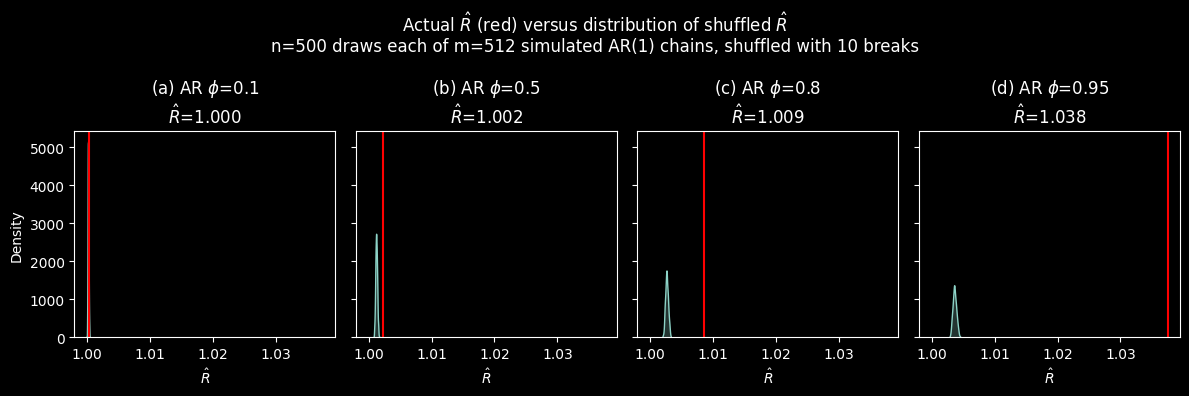

In [16]:
from statsmodels.tsa.arima_process import ArmaProcess

ars = [0.1, 0.5, 0.8, 0.95]
fig, axes = plt.subplots(1, len(ns), figsize=(12, 4), sharex=True, sharey=True)
brks = 10
n = 500
for i, (ax, ar) in enumerate(zip(axes.ravel(), ars)):
    ardraws = np.stack([ArmaProcess(np.array([1, -ar]), np.array([1])).generate_sample(nsample=n, burnin=50) for _ in range(m)])
    assess_rhat(ardraws, r'$\theta$', breaks=brks, ax=ax)
    a = chr(ord('a') + i)
    this_rhat = compute_rhat(ardraws)
    ax.set_title(f'({a}) AR $\phi$={ar}\n$\\hat{{R}}$={this_rhat:.3f}')
fig.suptitle(f'Actual $\\hat{{R}}$ (red) versus distribution of shuffled $\\hat{{R}}$\nn={n} draws each of m={m} simulated AR(1) chains, shuffled with {brks} breaks')
plt.tight_layout()

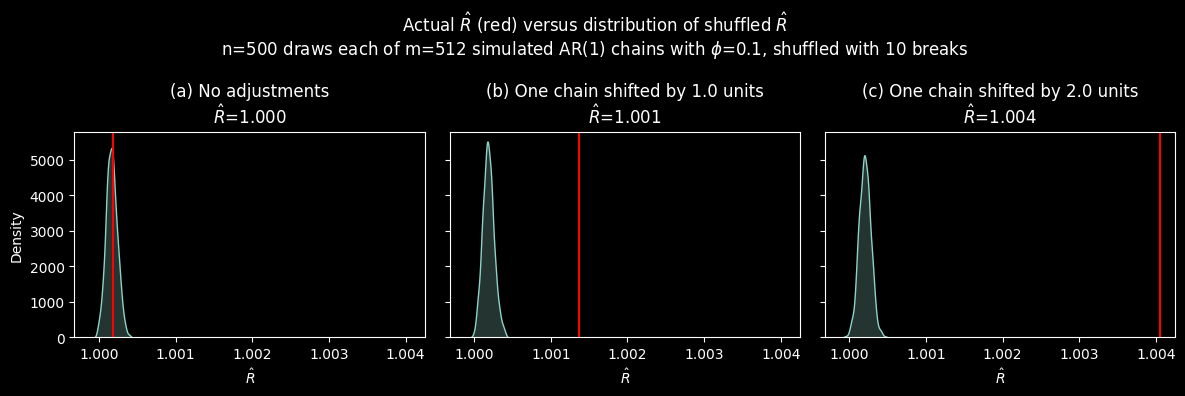

In [17]:
from statsmodels.tsa.arima_process import ArmaProcess

shifts = [0., 1.0, 2.]
n = 500
fig, axes = plt.subplots(1, len(shifts), figsize=(12, 4), sharex=True, sharey=True)
brks = 10
for i, (ax, shift) in enumerate(zip(axes.ravel(), shifts)):
    ardraws = np.stack([ArmaProcess(np.array([1, -0.1]), np.array([1])).generate_sample(nsample=n, burnin=50) + np.where(j==0, shift, 0) for j in range(m)])
    assess_rhat(ardraws, r'$\theta$', breaks=brks, ax=ax)
    a = chr(ord('a') + i)
    this_rhat = compute_rhat(ardraws)
    if shift:
        ax.set_title(f'({a}) One chain shifted by {shift} units\n$\\hat{{R}}$={this_rhat:.3f}')
    else:
        ax.set_title(f'({a}) No adjustments\n$\\hat{{R}}$={this_rhat:.3f}')
fig.suptitle(f'Actual $\\hat{{R}}$ (red) versus distribution of shuffled $\\hat{{R}}$\nn={n} draws each of m={m} simulated AR(1) chains with $\\phi$=0.1, shuffled with {brks} breaks')
plt.tight_layout()